<a href="https://colab.research.google.com/github/bpbista/AI-App-Flowers-Classifier/blob/master/AI_App_Flowers_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Install proper version of PyTorch
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install --no-cache-dir -I pillow
# !pip install Pillow==5.3.0
#Restart runtime after installation before further proceeding

In [0]:
# Imports required modules
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as fun
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json
from google.colab import drive
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
isGPU = torch.cuda.is_available();

In [0]:
# Mount and list google drive
# This will prompt for authorization.
drive.mount('/content/drive')
!ls -l "/content/drive/My Drive/PyTorch/Datasets/flower_data"
!ls -l "/content/drive/My Drive/PyTorch/Models"

root = '/content/drive/My Drive/PyTorch/'
data_dir = root+'Datasets/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
labels_data = data_dir + '/cat_to_name.json'
trained_model_dir = root + 'Models/'

In [9]:
with open(labels_data, 'r') as f:
    cat_to_name = json.load(f)
    print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [0]:
# number of subprocesses to use for data loading
num_workers = 8

# how many samples per batch to load
batch_size = 32
test_batch_size = 20

# image size should be 224 for pretrained model
image_size = 224 

# first upload flower_data in google drive
# DONE: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(image_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(image_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]) 
# DONE: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms) 

# DONE: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=num_workers)

class_names = train_data.classes
images, labels = next(iter(train_loader))
# class_to_idx = {sorted(train_data.classes)[i]: i for i in range(len(train_data.classes))}
class_to_idx = train_data.class_to_idx
labels_to_class = dict((v,k) for k,v in class_to_idx.items())



In [11]:
print(labels_to_class)
print(class_to_idx)
print(class_names)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [12]:
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
trainset_size = str(len(train_data))
validset_size = str(len(valid_data))
print('Train Data Size:')
print(trainset_size)
print('Valid Data Size:')
print(validset_size)
print('Classes:')
print(len(class_names))
# class_names = cat_to_name
# Print one batch of training images, tensor
print(labels)
print(labels.size())
print(images.size())

Train Data Size:
6552
Valid Data Size:
822
Classes:
102
tensor([76,  8, 44, 73, 72, 82, 49, 38, 75, 98, 83,  5, 56,  3,  0, 88, 82, 77,
        42, 93, 43, 79, 34, 70, 46, 88, 20, 89, 40, 48, 47, 43])
torch.Size([32])
torch.Size([32, 3, 224, 224])


In [0]:
def imshow(image, title=None):
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1,2,0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    ## Undo preprocessing
    image = (image * std) + mean
    
    ## Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    if title is not None:
      plt.title(title)

Class to idx
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '9

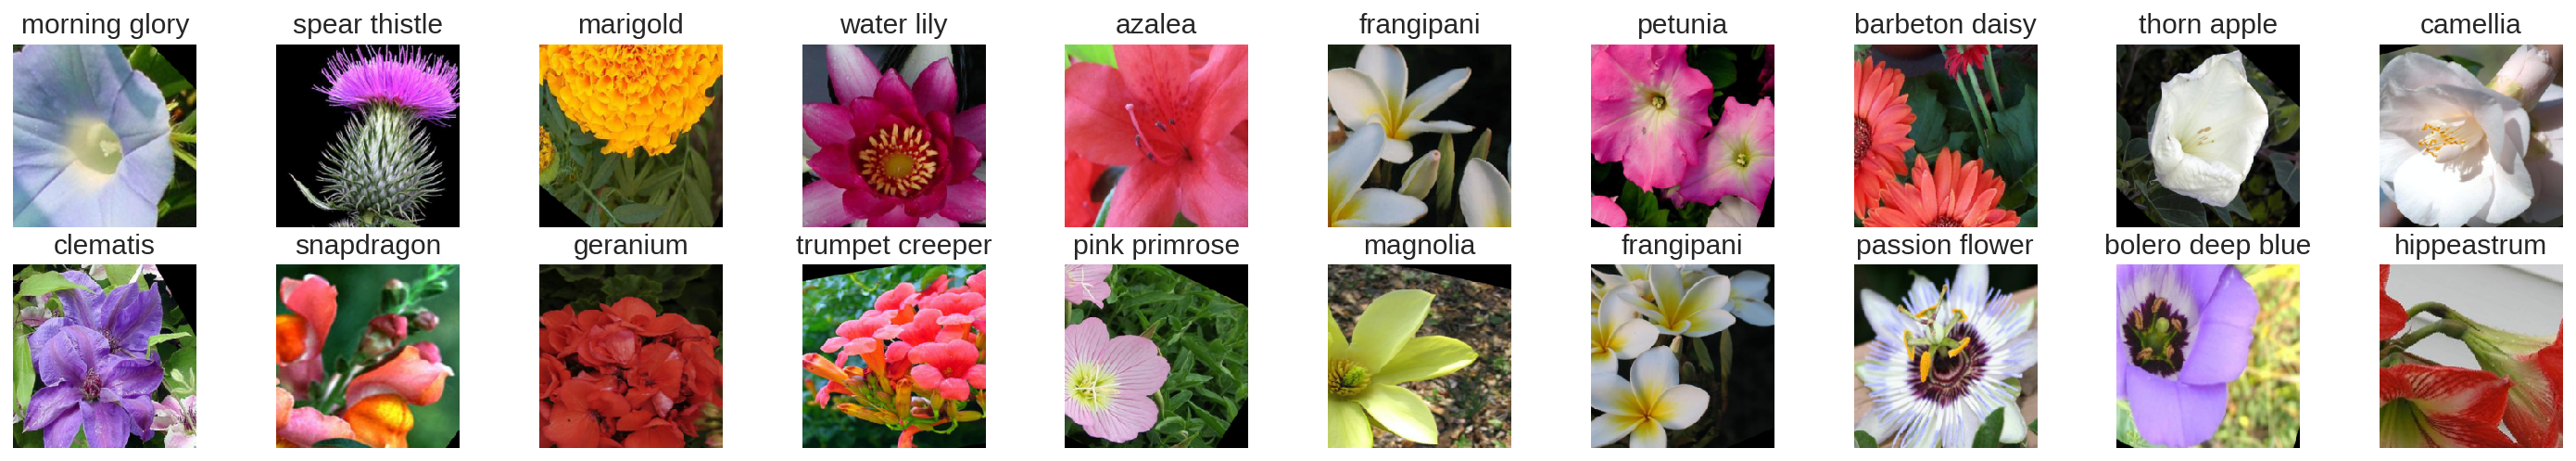

In [14]:
print("Class to idx")
print(class_to_idx)
print("Labels to class")
print(labels_to_class)     
print()
print("Torch Size for every batch")
print(images.shape)
print()
print("Labels for the above batch")
print(labels)

# Make a grid from batch
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize = (25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(label = cat_to_name[labels_to_class[labels[idx].item()]], fontsize=15)

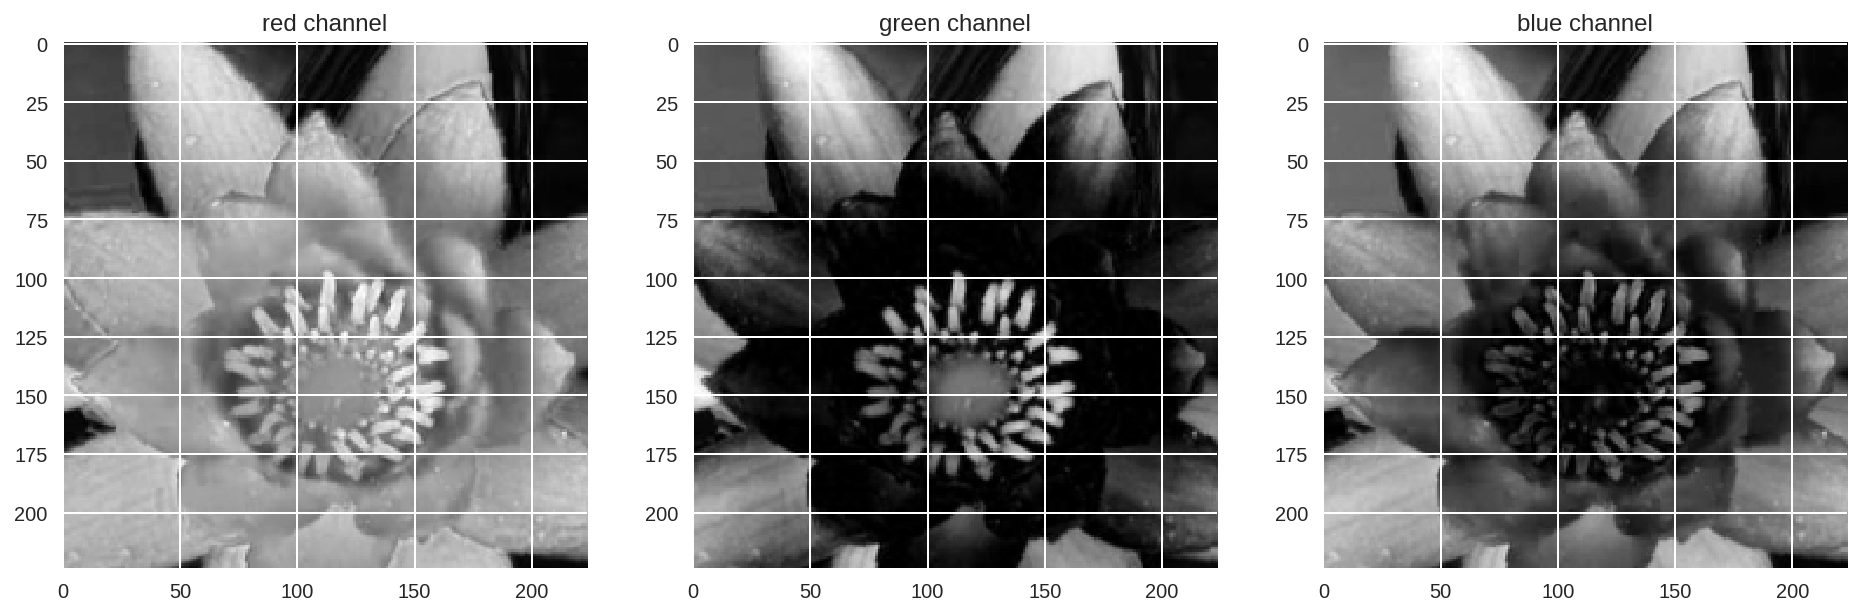

In [18]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (16, 16)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5

In [0]:
# Hyperparameters
lr = 0.0001
dropout = 0.25

#Choose any pretrained architecture here
arch = 'densenet161'
hidden_layer = 512
archs = {
    "vgg16":25088,
    "vgg19":25088,
    "densenet121" : 1024,
    "densenet169" : 1664,
    "densenet161" : 2208,
    "alexnet" : 9216,
    "resnet152" : 2048,
    "resnet101" : 2048
}

In [0]:
def nn_setup(arch='vgg16', dropout=dropout, hidden_layer = hidden_layer, lr = lr):
    
    if arch == 'vgg16':
      model = models.vgg16(pretrained=True)  
    elif arch == 'vgg19':
      model = models.vgg19(pretrained=True)
    elif arch == 'densenet121':
      model = models.densenet121(pretrained=True)
    elif arch == 'densenet169':
      model = models.densenet169(pretrained=True)
    elif arch == 'densenet161':
      model = models.densenet161(pretrained=True)
    elif arch == 'alexnet':
      model = models.alexnet(pretrained = True)
    elif arch == 'resnet152':
      model = models.resnet152(pretrained=True)
    elif arch == 'resnet101':
      model = models.resnet101(pretrained=True)
    else:
        print("Im sorry but {} is not a valid model.Did you mean vgg16,densenet121,or alexnet?".format(structure))
    
    for param in model.parameters():
      # freese (False) and unfreeze (True) paramters here
      param.requires_grad = True
        
    classifier = nn.Sequential(OrderedDict([
        ('dropout',nn.Dropout(dropout)),
        ('fc1', nn.Linear(archs[arch], hidden_layer)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layer, 102))
#         ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    
    criterion = nn.CrossEntropyLoss()
    
    # Alternative criterion & optimizer
#     criterion = nn.NLLLoss()
#     optimizer = optim.Adam(model.classifier.parameters(), lr )
#     optimizer = optim.Adagrad(model.classifier.parameters(), lr )
#     optimizer = optim.RMSprop(model.classifier.parameters(), lr )
#     optimizer = optim.SGD(model.classifier.parameters(), lr,  momentum=0.9) # train only classifier if freezed  

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # train whole model
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
        
    if isGPU:
      print("Training on GPU CUDA")
      model.to(device)
        
    return model , optimizer ,criterion, scheduler 
  
model, optimizer, criterion, scheduler = nn_setup(arch)

In [0]:
def setData(model):
  # Data to be saved after training the model
  savedata = {
      'arch': arch,
      'classifier': model.classifier,
      'state_dict': model.state_dict(),
      'class_to_idx': class_to_idx,
      'criterion_state': criterion.state_dict(),
      'optimizer_state': optimizer.state_dict(),
      'epochs': epochs,
      'hidden' : hidden_layer,
      'lr':lr,
      'batch_size': batch_size,
      'test_batch_size': test_batch_size,
      'highest_accuracy': highest_accuracy,
      'labels_to_class': labels_to_class,
      'scheduler': scheduler,
      'cat_to_name': cat_to_name,
      'class_names': class_names,
      'dropout': dropout,
      'image_size': image_size
  }
  return savedata

In [22]:
# load the states of the previously trained model, 
# if the model is being first time trained then not run this cell

checkpoint = torch.load(trained_model_dir + 'densenet161_classifier.pt')
model.load_state_dict(checkpoint['state_dict'], strict=False)
highest_accuracy = checkpoint['highest_accuracy']
print(highest_accuracy)

tensor(0.9952)


In [0]:
# number of epochs to train the model, 
# Initially train the model with fewer epochs

epochs = 50
print_every = 5
steps = 0
loss_show=[]

training_losses = []
validation_losses = []

# uncomment following line, if training is running first time
# highest_accuracy = 0#0.9952

# change to cuda
model.to('cuda')

for e in range(epochs):
    running_loss = 0 
    
    scheduler.step()
    
    print(f'\nEpoch {e+1} of {epochs} lr {scheduler.get_lr()}\n------------------------------------------------------------------')
#    print(f'\nEpoch {e+1} of {epochs} lr {lr}\n------------------------------------------------------------------')
    
    ###################
    # train the model #
    ###################

    for ii, (inputs, labels) in enumerate(train_loader):
        steps += 1
        
        model.train()
        inputs,labels = inputs.to('cuda'), labels.to('cuda')
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model.forward(inputs)
        
        # calculate the loss
        loss = criterion(outputs, labels)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            vlost = 0
            accuracy=0
            
            for ii, (inputs2,labels2) in enumerate(valid_loader):
                optimizer.zero_grad()
                
                inputs2, labels2 = inputs2.to('cuda:0') , labels2.to('cuda:0')
                model.to('cuda:0')
                with torch.no_grad():    
                    outputs = model.forward(inputs2)
                    vlost = criterion(outputs,labels2)
                    ps = torch.exp(outputs).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            vlost = vlost / len(valid_loader)
            accuracy = accuracy /len(valid_loader)
            
            #Save most accurate model
            if accuracy >= highest_accuracy :
              highest_accuracy = accuracy
              savedata = setData(model)
              torch.save(savedata, trained_model_dir + 'densenet161_classifier.pt')
                    
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Valid Loss {:.6f}".format(vlost),
                   "Accuracy: {:.6f}".format(accuracy*100))
            
            #Plot losses data
            training_losses.append(running_loss/len(train_loader)) 
            validation_losses.append(vlost)
            
            running_loss = 0            
            
            
    if scheduler.get_lr()[0] < 0.00001:
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
      print(f'\nReset scheduler lr {scheduler.get_lr()}\n---------------------------')

In [0]:
# plot losses
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.legend(frameon=False)
plt.show()

In [0]:
# this is required if you want to check accuracy of the trained model
!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install requests
!pip install airtable
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')
from test_model_pytorch_facebook_challenge import publish_evaluated_model, calc_accuracy

In [29]:
# check the accuracy
model.eval()
calc_accuracy(model, input_image_size=image_size, testset_path=test_dir)

Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Mean accuracy: 0.9903846383094788


0.99038464

In [0]:
# if you like to save manualy last state of the model, run the following line
# torch.save(savedata, trained_model_dir + 'densenet161_classifier.pt')

In [0]:
# Publish your model accuracy to the following airtable. Reminder: first modify your username and other parameters
# https://airtable.com/shrCs1LDFdBus0tMG/tblqGWCxC2JZQ4Sst/viw9ilG0MslfkRooW
publish_evaluated_model(model, input_image_size=224,  username="@BP Bista", model_name="densenet161", optim="SGD", criteria="CrossEntropyLoss", scheduler="StepLR", epoch=100)